###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2021 Lorena A. Barba, Tingyu Wang

# Polynomial Regression

In this fourth lesson of the _Engineering Computations_ module on deep learning, we play with a different model-building method: polynomial regression. 
We already saw one case in which the observational data could not be fit by a line, and that was the classification problem that we tackled with logistic regression (Lesson 3). 
Now imagine that your data wiggles about on the $x, y$ plane—where $x$ is the independent variable or feature, and $y$ is the dependent variable. 
You look at it and think: a curvilinear relationship might work. Good idea. 

It may surprise you to learn that fitting a polynomial to the data is a special case of multiple linear regression. Yes: _linear_. 
When we talk about linear models, we mean linear with respect to the parameters!

## A special case of multiple linear regression

Let's generate some synthetic data using a polynomial function of fourth order, $y = x^4 + x^3 - 4x^2 $, with a bit of added noise.

As usuall, we start by loading some needed Python libraries and functions, including the useful tools from `autograd` that you've learned about already.

In [1]:
from matplotlib import pyplot as plt
from autograd import grad
import autograd.numpy as np

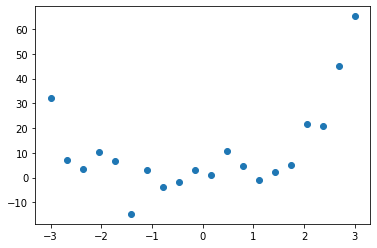

In [2]:
np.random.seed(0)    # fix seed for reproducibility
x = np.linspace(-3, 3, 20)
y = x**4 + x**3 - 4*x**2 + 8*np.random.normal(size=len(x))
plt.scatter(x, y);

Suppose we were only given the data (not the function that generated them), and our goal is to fit a curve to these data. The nonlinear relationship between $x$ and $y$ suggests that a linear regression will fail. Intuitively, using polynomial functions may first come to your mind.

Let's write the model as a $d$th-order polynomial on $x$, the only feature:

$$
\hat{y} = w_0 + w_1 x + w_2 x^2 + \cdots + w_d x^d, 
$$

where $w$ denotes the weights. Keep in mind that in the model-fitting context, the objective is always to find the optimal values of these weights given $x$ and $y$. When viewed from a different perspective, the model above is just a linear combination of the weights. In fact, by creating polynomial features of $x$, namely, letting $x_i = x^i$, the model becomes:

$$
\hat{y} = w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_d x_d.
$$

As you can see, the polynomial regression model is identical to multiple linear regression, with the matrix form being also $\hat{\mathbf{y}} = X\mathbf{w}$, and the only gap is forming the matrix $X$ using the powers of $x$.

Suppose we want to fit our data with a 3rd degree polynomial function; let's write a function to create these polynomial features first.

In [3]:
degree = 3

def polynomial_features(x, degree):
    """ Generate polynomial features for x."""
    
    X = np.empty((len(x), degree+1))
    for i in range(degree+1):
        X[:,i] = x**i
    return X

X = polynomial_features(x, degree)
print(X.shape)

(20, 4)


##### Note

> Unsurprisingly, **scikit-learn** offers a counterpart: [`PolynomialFeatures()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).
When your original data come with multiple features (e.g., $x_1$ and $x_2$), the polynomial features for regression will involve interaction terms (e.g., $x_1 x_2$ for 2nd-order polynomials).
In that case, it is handy to use this function to generate all terms.

## Scale the data, train the model

Recall that for multiple linear regression, we should normalize each feature to the same scale.
As in the previous lesson, let's use `MinMaxScaler()` to scale all features to $[0,1]$, except for the first column:
$x_0$ is set to 1 for all entries, since $w_0$ represents the intercept.

In [4]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled[:,0] = 1   # the column for intercept

When scaling the matrix of polynomial features $X$ above, we used:
```python
X_scaled = min_max_scaler.fit_transform(X)
```
The function `fit_transform()` is actually a combination of two steps:
- [`fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler.fit): compute $x_{\min}$ and $x_{\max}$ values for each feature and save the information to the variable `min_max_scaler`. You can access them via `min_max_scaler.data_min_` and `min_max_scaler.data_max_`.
- [`transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler.transform) use `min_max_scaler` to scale `X`.

This will be helpful to remember a bit later.

We can reuse the same model and loss function from Lesson 3:

In [5]:
def linear_regression(params, X):
    '''
    The linear regression model in matrix form.
    Arguments:
      params: 1D array of weights for the linear model
      X     : 2D array of input values
    Returns:
      1D array of predicted values
    '''
    return np.dot(X, params)

def mse_loss(params, model, X, y):
    '''
    The mean squared error loss function.
    Arguments:
      params: 1D array of weights for the linear model
      model : function for the linear regression model
      X     : 2D array of input values
      y     : 1D array of predicted values
    Returns:
      float, mean squared error
    '''
    y_pred = model(params, X)
    return np.mean( np.sum((y-y_pred)**2) )

gradient = grad(mse_loss)

Remember, "training" a model simply means finding the best parameters by minimizing a loss function. 
We'll choose both a maximum number of iterations in the optimization loop, and an exit criterion based on the norm of the gradient at the current iteration. 
(If this is quite small, when multiplied by the also-small learning rate, the parameters will change very little.)

In [6]:
max_iter = 3000
alpha = 0.01
params = np.zeros(X_scaled.shape[1])
descent = np.ones(X_scaled.shape[1])
i = 0

from sklearn.metrics import mean_absolute_error

while np.linalg.norm(descent) > 0.01 and i < max_iter:
    descent = gradient(params, linear_regression, X_scaled, y)
    params = params - descent * alpha
    loss = mse_loss(params, linear_regression, X_scaled, y)
    mae = mean_absolute_error(y, X_scaled@params)
    if i%100 == 0:
        print(f"iteration {i:4}, {loss = :.3f}, {mae = :.3f}")
    i += 1

iteration    0, loss = 5434.768, mae = 11.057
iteration  100, loss = 1300.477, mae = 6.885
iteration  200, loss = 1281.309, mae = 6.864
iteration  300, loss = 1272.990, mae = 6.808
iteration  400, loss = 1267.448, mae = 6.760
iteration  500, loss = 1263.750, mae = 6.722
iteration  600, loss = 1261.282, mae = 6.690
iteration  700, loss = 1259.636, mae = 6.664
iteration  800, loss = 1258.537, mae = 6.643
iteration  900, loss = 1257.804, mae = 6.625
iteration 1000, loss = 1257.314, mae = 6.611
iteration 1100, loss = 1256.988, mae = 6.600
iteration 1200, loss = 1256.770, mae = 6.590
iteration 1300, loss = 1256.625, mae = 6.583
iteration 1400, loss = 1256.528, mae = 6.576
iteration 1500, loss = 1256.463, mae = 6.571
iteration 1600, loss = 1256.420, mae = 6.567
iteration 1700, loss = 1256.391, mae = 6.564
iteration 1800, loss = 1256.372, mae = 6.561
iteration 1900, loss = 1256.359, mae = 6.558
iteration 2000, loss = 1256.350, mae = 6.557
iteration 2100, loss = 1256.345, mae = 6.555
iteration

Let's print out the weights.

In [7]:
params

array([-22.51572398,   6.75930601,  41.30788709,  30.0105898 ])

The first term is the intercept, and the rest are the weights of each **scaled** polynomial feature.

Although our model has multiple weights, there's only one feature in our original data. 
Therefore, if we are given new values of $x$ to predict $y$, we need to first create the polynomial features, scale them to $[0,1]$ using the **same scaling function**, and then multiply by the weights. Since we have used the min-max scaling, it is important to use the same $x_{\min}$ and $x_{\max}$ of the training data to scale new data.

Recall the explanation above for the scaling step. We now only need to call `min_max_scaler.transform()` to scale new data. Such design occurs very often in scikit-learn.

With that in mind, let's plot the fitted curve together with the data. We generate some new values of $x$, `xgrid`, and predict $y$ at these locations. Don't forget to repeat the procedure of creating polynomial features and scaling them. Ponder over this code for a moment to wrap your head around it.

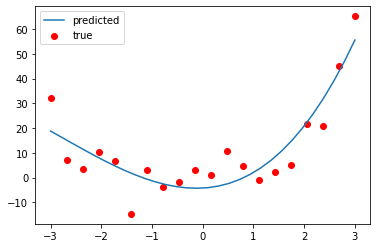

In [8]:
xgrid = np.linspace(x.min(), x.max(), 30)
Xgrid_poly_feat = polynomial_features(xgrid, degree)
Xgrid_scaled = min_max_scaler.transform(Xgrid_poly_feat)
Xgrid_scaled[:,0] = 1 
plt.scatter(x, y, c='r', label='true')
plt.plot(xgrid, Xgrid_scaled@params, label='predicted')
plt.legend();

## Observe underfitting & overfitting

In the model above, we just randomly picked a polynomial degree of $3$ for the fitted curve. Is it good enough to model our dataset? Should we try higher-order polynomials?

We can repeat our study with different polynomial degrees varying from $1$ to $15$, and see what happens.
To faciliate this task, we provide you with a script to train the model and plot these fitted curves interactively using `ipywidget`.

Run the cell below and drag the slider to see how the curve changes.

In [9]:
import sys
sys.path.append('../scripts/')
from plot_helpers import interact_polyreg

max_degree = 15
interact_polyreg(max_degree, x, y)

interactive(children=(IntSlider(value=8, description='degree', max=15, min=1), Output()), _dom_classes=('widge…

### Underfitting

When `degree` is $1$, the straight line clearly fails to capture the underlying relationship between $x$ and $y$. Specifically, a line is too simple to explain how far the data are spread out, namely, the **variance** in the data. We say that the linear model **underfits** the data in this case.

Underfitting happens when the model is too naive or the weights need to be trained with more iterations. It is often easy to detect, since a large training error is a good indicator.

##### Challenge question

> Would having more training data help resolve underfitting?

### Overfitting

As we increase the polynomial degree, the training error (MAE from the figure title) keeps decreasing. 
But does it mean that the 15th-order polynomial gives the best fit?
Probably not.

Drag the slider to the right, and you will find that the curve passes exactly through many points and looks very odd.
If we are given new data, this model may not predict well because it fits too closely to the old data.
As real-world data tend to be noisy (due to missing and erroneous values), our synthetic data also have noise added.
Models with high polynomial degrees are so flexible that they fit the noise rather than the true relationship! 
In this case, these models are **overfitting**, or have a **high variance**.
Overfitting usually happens when the model is overly complicated.
The high-order polynomials in our example have too many degrees of freedom (weights) for our data.

##### Challenge question

> Would having more training data help resolve overfitting?

Compared to underfitting, overfitting is in general harder to detect because the training error tends to be small. We will discuss how to identify overfitting later in this module.
Now let's focus on how to prevent overfitting using regularization.

## Regularization

Regularization is used to reduce or avoid overfitting.
The idea is to introduce a term in the loss function that penalizes complicated models. In our polynomial regression model:

$$
\hat{y} = w_0 + w_1 x + w_2 x^2 + \cdots + w_d x^d,
$$

every polynomial term contributes to the overall complexity of the model.
One idea is to add constraints to the magnitudes of these weights.

A common approach is to add a regularization term $\lambda\sum_{j=1}^d w_j^2$ to the mean-squared error loss:

$$
L(\mathbf{w})=\frac{1}{N} {\lVert \mathbf{y} - X\mathbf{w} \rVert}^2 + \lambda \sum_{j=1}^d w_j^2
$$

This new loss function favors smaller weights, because larger weights will increase the term on the right.
As weights are smaller, the model is less likely to overfit by large amplitude higher-order polynomial terms.

Notice that we don't penalize the intercept $w_0$ in the regularization term. This can be justified mathematically, but one way to think about it is that a constant term won't affect the overall model complexity.

Above, $\lambda$ denotes the regularization parameter, or the strength of penalty. It controls the tradeoff between fitting the data well (minimizing the first term) and keeping the model simple to avoid overfitting (minimizing the second term). When $\lambda\rightarrow 0$, the loss function falls back to standard mean-square error loss. And when $\lambda$ is large, all penalized weights will be close to 0 after training and our model would approach the constant value $w_0$.

##### Note

> This regularization is also called $L^2$-penalty, or Tikhonov regularization, while the name _ridge regression_ is also used for this model-building method.

Let's code the regularized mean-squared error loss and set $\lambda = 1$.

In [10]:
def regularized_loss(params, model, X, y, _lambda=1.0):
    '''
    The mean squared error loss function with an L2 penalty.
    Arguments:
      params: 1D array of weights for the linear model
      model : function for the linear regression model
      X     : 2D array of input values
      y     : 1D array of predicted values
      _lambda: regularization parameter, default 1.0
    Returns:
      float, regularized mean squared error
    '''
    y_pred = model(params, X)
    return np.mean( np.sum((y-y_pred)**2) ) + _lambda * np.sum( params[1:]**2 )

gradient = grad(regularized_loss)                                                        

In [11]:
no_regularization_params = params.copy()

And train the 3rd-degree polynomial model using gradient descent.

In [12]:
max_iter = 3000
alpha = 0.01
params = np.zeros(X_scaled.shape[1])
descent = np.ones(X_scaled.shape[1])
i = 0

from sklearn.metrics import mean_absolute_error

while np.linalg.norm(descent) > 0.01 and i < max_iter:
    descent = gradient(params, linear_regression, X_scaled, y)
    params = params - descent * alpha
    loss = mse_loss(params, linear_regression, X_scaled, y)
    mae = mean_absolute_error(y, X_scaled@params)
    if i%100 == 0:
        print(f"iteration {i:4}, {loss = :.3f}, {mae = }")
    i += 1

iteration    0, loss = 5434.768, mae = 11.05718775676392
iteration  100, loss = 1785.985, mae = 6.983886996350374
iteration  200, loss = 1764.260, mae = 6.966518785947395
iteration  300, loss = 1763.570, mae = 6.965728405272657


Let's compare the optimal weights before and after regularization. We can reuse the `xgrid` to plot both curves.

weights without regularization
[-22.51572398   6.75930601  41.30788709  30.0105898 ]
weights with regularization
[-11.13750882  12.48522096  28.26626633  11.09211867]


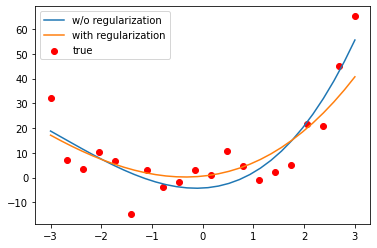

In [13]:
print("weights without regularization")
print(no_regularization_params)
print("weights with regularization")
print(params)

plt.scatter(x, y, c='r', label='true')
plt.plot(xgrid, Xgrid_scaled@no_regularization_params, label='w/o regularization')
plt.plot(xgrid, Xgrid_scaled@params, label='with regularization')
plt.legend();

Using our helper script again to display both models with varying polynomial degree in an `ipywidget`, interact with the slider to explore the results. We set `regularized=True` this time.

In [14]:
interact_polyreg(max_degree, x, y, regularized=True)

interactive(children=(IntSlider(value=8, description='degree', max=15, min=1), Output()), _dom_classes=('widge…

Thanks to the regularization term, you won't see the wiggling curves even with a high degree polynomial, since the magnitude of the weights (the coefficients before each polynomial term) is much smaller.

## Ridge regression with scikit-learn

You won't be surprised by now that **scikit-learn** offers a method to obtain a linear model with regularization: [`Ridge()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge). 
Look and ponder at the code cell below, where we call `Ridge()` and its `.fit()` method to fit the ridge regression model with our scaled matrix of features (also called the _design matrix_) and the $y$ data.
The default value of the penalization parameter of $1.0$, so we don't specify it, but if you wanted to try a different value, you specify it as `alpha=value` in the argument list. Do explore the documentation page.

[12.48291164 28.26642615 11.09583654]
-11.138315887456029


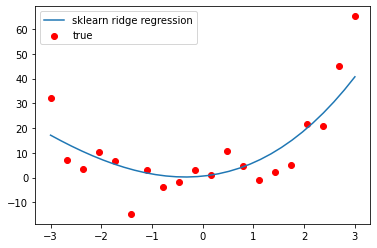

In [15]:
from sklearn.linear_model import Ridge

model = Ridge().fit(X_scaled[:, 1:], y) # Ridge() by default fits an intercept
y_pred_sklearn = model.predict(Xgrid_scaled[:,1:])

print(model.coef_)
print(model.intercept_)

plt.scatter(x, y, c='r', label='true')
plt.plot(xgrid, y_pred_sklearn, label='sklearn ridge regression')
plt.legend();


The `model` variable we created above using `Ridge()` stores the model weights and the intercept in the `.coef_` and `intercept_` attributes. 
Compare the values with those we obtained above using the regularization and 3rd-order polynomial. Pretty close!

## What we've learned

- Polynomial regression is a special case of multiple linear regression.
- Pick too low-order a polynomial (e.g., a line) and the model could _underfit_ the data, giving large residuals (training error).
- Pick too high a polynomial order, and you will get _overfitting_, as the model tries to fit the noise in the data resulting in wiggles.
- Regularization is used to reduce or avoid overfitting.
- Adding the sum-of-squares of the weights to the loss function _penalizes_ large weights and controls overfitting. 
- Linear regression with this so-called Tikhonov regularization is called _ridge regression_.
- With **scikit-learn**, you can use `Ridge()` to fit a linear model with regularization. 

In [16]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())